# 03. PyTorch Computer Vision Exercises

### 5. Load the `torchvision.datasets.MNIST()` train and test datasets.

In [136]:
import torch
import torch.nn as nn
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt

In [137]:
from helper_functions import accuracy_fn

In [138]:
import torchvision
from torchvision import datasets

train_data = datasets.MNIST(root='data', train=True, download=True, transform=torchvision.transforms.ToTensor(), target_transform=None)

# Setup testing data
test_data = datasets.MNIST(root='data', train=False, download=True, transform=torchvision.transforms.ToTensor(), target_transform=None)

In [139]:
len(train_data), len(test_data)

(60000, 10000)

### 6. Visualize at least 5 different samples of the MNIST training dataset.

In [140]:
class_names = train_data.classes

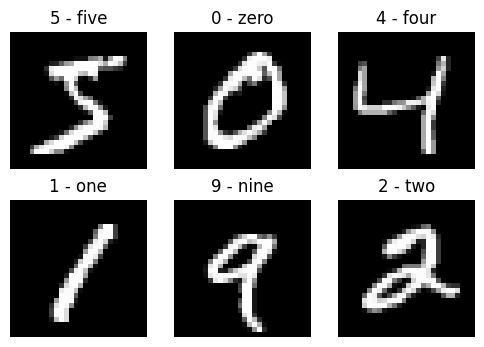

In [141]:
fig = plt.figure(figsize=(6, 4))
rows, cols = 2, 3
for i in range(0, rows * cols):
    img, label = train_data[i]
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

### 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [142]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into batches
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [143]:
print(f"DataLoaders: train_dataloader, test_dataloader")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: train_dataloader, test_dataloader
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


### 8. Recreate `model_2` used in notebook 03 capable of fitting on the MNIST dataset.

In [144]:
class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*hidden_units, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        # print(f"Input shape: {x.shape}")
        x = self.block_1(x)
        # print(f"After block_1 shape: {x.shape}")
        x = self.block_2(x)
        # print(f"After block_2 shape: {x.shape}")
        x = self.classifier(x)
        # print(f"After classifier shape: {x.shape}")
        return x

In [145]:
torch.manual_seed(42)
model = MNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names))
model

MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [146]:
device='cpu'

In [147]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [148]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training loop step on model trying to learn on dataloader"""
    train_loss, train_acc = 0, 0
    
    # Put model into training model
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)
        
        # 2. Calculate loss and accuracy / batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step (updating parameters once/batch)
        optimizer.step()
        
    # Divide total train loss and acc by length of train_dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")

In [149]:
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, 
              accuracy_fn, 
              device: torch.device = device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, test_acc = 0, 0
    
    # Put the model in eval mode
    model.eval()
    
    # Turn on inference mode
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))   # logits -> prediction labels
            
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

In [150]:
torch.manual_seed(42)

from timeit import default_timer as timer
from tqdm import tqdm

start_timer = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: epoch")
    train_step(data_loader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: epoch


  0%|          | 0/3 [00:10<?, ?it/s]


KeyboardInterrupt: 

### 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of a model predicting on data loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values / batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc to find the average loss or acc / batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_name': model.__class__.__name__,     # Only works when model was created with a class
            'model_loss': loss.item(),
            'model_acc': acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn)
model_0_results

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

{'model_name': 'MNISTModel',
 'model_loss': 0.0727819874882698,
 'model_acc': 97.58386581469648}

### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [ ]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   2%|▏         | 5/313 [00:00<00:06, 46.91it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:   6%|▌         | 19/313 [00:00<00:04, 64.30it/s]

After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Si

Making predictions:  12%|█▏        | 37/313 [00:00<00:03, 75.95it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  17%|█▋        | 53/313 [00:00<00:03, 75.09it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  22%|██▏       | 70/313 [00:00<00:03, 77.50it/s]

After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Siz

Making predictions:  28%|██▊       | 88/313 [00:01<00:02, 80.02it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  34%|███▍      | 106/313 [00:01<00:02, 81.20it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  37%|███▋      | 115/313 [00:01<00:02, 66.94it/s]

After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Siz

Making predictions:  43%|████▎     | 134/313 [00:01<00:02, 76.63it/s]

After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Siz

Making predictions:  49%|████▉     | 153/313 [00:02<00:01, 81.89it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  55%|█████▌    | 173/313 [00:02<00:01, 87.36it/s]

After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Siz

Making predictions:  61%|██████▏   | 192/313 [00:02<00:01, 88.08it/s]

After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Siz

Making predictions:  67%|██████▋   | 210/313 [00:02<00:01, 84.96it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  73%|███████▎  | 228/313 [00:02<00:01, 84.90it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  76%|███████▌  | 237/313 [00:03<00:00, 77.02it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  81%|████████  | 253/313 [00:03<00:00, 70.45it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  86%|████████▌ | 269/313 [00:03<00:00, 72.60it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  91%|█████████▏| 286/313 [00:03<00:00, 75.74it/s]

Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10

Making predictions:  94%|█████████▍| 295/313 [00:03<00:00, 78.06it/s]

After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Si

Making predictions: 100%|██████████| 313/313 [00:04<00:00, 75.65it/s]

After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Size([32, 10, 7, 7])
After classifier shape: torch.Size([32, 10])
Input shape: torch.Size([32, 1, 28, 28])
After block_1 shape: torch.Size([32, 10, 14, 14])
After block_2 shape: torch.Siz

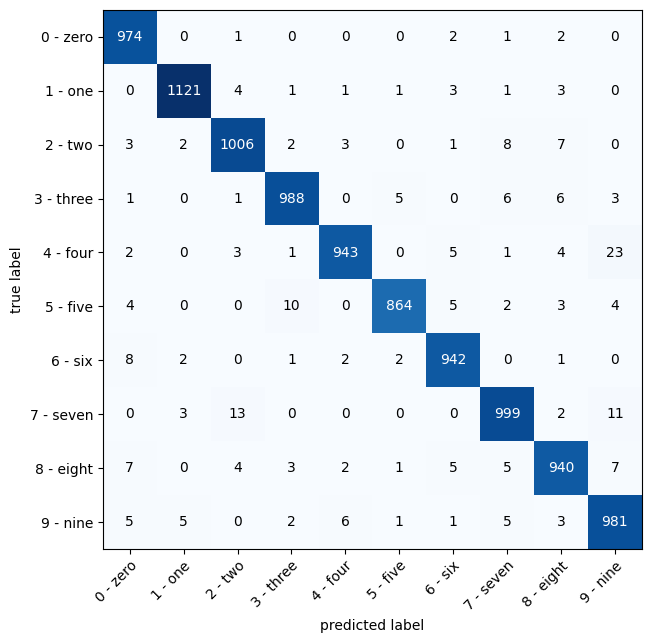

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),    # matplotlib likes working with NumPy 
    class_names=class_names,            # turn the row and column labels into class names
    figsize=(10, 7)
)

### 12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [155]:
input_tensor = torch.randn(1, 3, 64, 64)

in_channels = 3
out_channels = 16
kernel_size = [8, 16, 32, 64]
stride = 1
padding = 1

for k in kernel_size:
    conv_layer = nn.Conv2d(in_channels, out_channels, k, stride, padding)
    output_tensor = conv_layer(input_tensor)
    print(k, output_tensor.shape)

8 torch.Size([1, 16, 59, 59])
16 torch.Size([1, 16, 51, 51])
32 torch.Size([1, 16, 35, 35])
64 torch.Size([1, 16, 3, 3])


As kernel size increases, the features of the image are compressed more, resulting in a smaller feature map.

### 13. Use a model similar to the trained model_2 from this notebook to make predictions on the test torchvision.datasets.FashionMNIST dataset.
Then plot some predictions where the model was wrong alongside what the label of the image should've been.
After visualing these predictions do you think it's more of a modelling error or a data error?
As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

Already solved in main notebook.